In [1]:
import os
import math
import random
import argparse
from collections import Counter, defaultdict
from itertools import chain, combinations
import ast
import copy
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
import os
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
import numpy as np
import pandas as pd
from collections import Counter

### Local Imports

In [2]:
from utils.Spambase.split_data import split_data_equal
from utils.aggregate_functions import aggregate_lr_models
from utils.evaluate_coalitions_new import evaluate_coalitions2
from utils.nash1 import find_nash_equilibria_v2
from utils.shapley_value import compute_and_visualize_shapley_values

# Spambase Dataset

In [ ]:
file_path = '...'  # Adjust the path as needed
df = pd.read_csv(file_path, header=None)

### Creating Global Train set and Test set and Preprocessing

In [4]:
random_seed= 42
X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Federated Learning (FedLR) _ without low-quality clients _ Spambase

In [5]:
def train_models_fedlr(partitions, random_seed, X_test, y_test, max_iter):
    client_models = []
    client_global_accuracies = []
    
    for X_i, y_i in partitions:
        # Clean data: remove rows with NaN values.
        nan_mask = ~np.isnan(X_i).any(axis=1)
        X_clean = X_i[nan_mask]
        y_clean = y_i[nan_mask]
        if len(y_clean) == 0:
            client_models.append(None)
            client_global_accuracies.append(None)
            continue
        
        model = LogisticRegression(random_state=random_seed, max_iter=max_iter)
        try:
            local_scaler = StandardScaler()
            model.fit(local_scaler.fit_transform(X_clean), y_clean)
            client_models.append(model)
            client_global_accuracies.append(model.score(X_test, y_test))
        except Exception as e:
            client_models.append(None)
            client_global_accuracies.append(None)
    
    return client_models, client_global_accuracies

#### Evaluating Grand coalition as a Nash Eq For Spambase in different Max_iter and number of clients Without LQC

In [6]:
# disable ConvergenceWarnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [ ]:
n_trials = 50
base_random_seed = 42
max_iters = [10,100]
approach = 'fedlr'

save_dir = "..."
os.makedirs(save_dir, exist_ok=True)

for n_clients in range(10, 101, 5):
    print(f"Running experiments for n_clients = {n_clients}")
    all_details_for_client = []  


    for max_iter in max_iters:
        nash_counts = Counter()
        details_for_this_param = []
        client_accuracy_details = []
        all_details = []


        for trial in range(n_trials):

            rand_component = random.randint(0, 500)
            trial_seed = base_random_seed + trial + int(1000 * max_iter) + 2 * rand_component


            partitions = split_data_equal(X_train, y_train, n_clients=n_clients,
                                          shuffle=True, random_seed=trial_seed)

            client_models, client_global_acc = train_models_fedlr(
                partitions=partitions,
                random_seed=trial_seed,
                X_test=X_test,
                y_test=y_test,
                max_iter=max_iter
            )


            df_results = evaluate_coalitions2(
                client_models=client_models,
                client_global_accuracies=client_global_acc,
                n_clients=n_clients,
                aggregator_func=aggregate_lr_models,
                X_test=X_test,
                y_test=y_test,
                corrupt_client_indices=[],
                approach=approach
            )
            df_results['Trial'] = trial + 1
            df_results['Max Iter or Depth'] = max_iter


            df_nash = find_nash_equilibria_v2(df_results.reset_index())
            if not df_nash.empty and 'Combination' in df_nash.columns:
                for coalition in df_nash['Combination']:
                    nash_counts[coalition] += 1


            df_nash['Trial'] = trial + 1
            df_nash['Max Iter or Depth'] = max_iter
            details_for_this_param.append(df_nash)


            trial_acc = {
                'Trial': trial + 1,
                'Max Iter or Depth': max_iter,
            }
            for j in range(n_clients):
                col_name = f'Client {j+1} Accuracy'
                trial_acc[col_name] = client_global_acc[j] if client_global_acc[j] is not None else np.nan
            client_accuracy_details.append(trial_acc)


        df_details = pd.concat(details_for_this_param, ignore_index=True)
        df_client_accuracy = pd.DataFrame(client_accuracy_details)
        df_combined = df_details.merge(
            df_client_accuracy,
            on=['Trial', 'Max Iter or Depth'],
            how='left'
        )

        df_combined['n_clients'] = n_clients
        all_details_for_client.append(df_combined)


    final_details_df = pd.concat(all_details_for_client, ignore_index=True)

    details_path = os.path.join(save_dir, f"Nash_Equilibrium_Details_{approach}_nclients_{n_clients}.csv")
    final_details_df.to_csv(details_path, index=False)

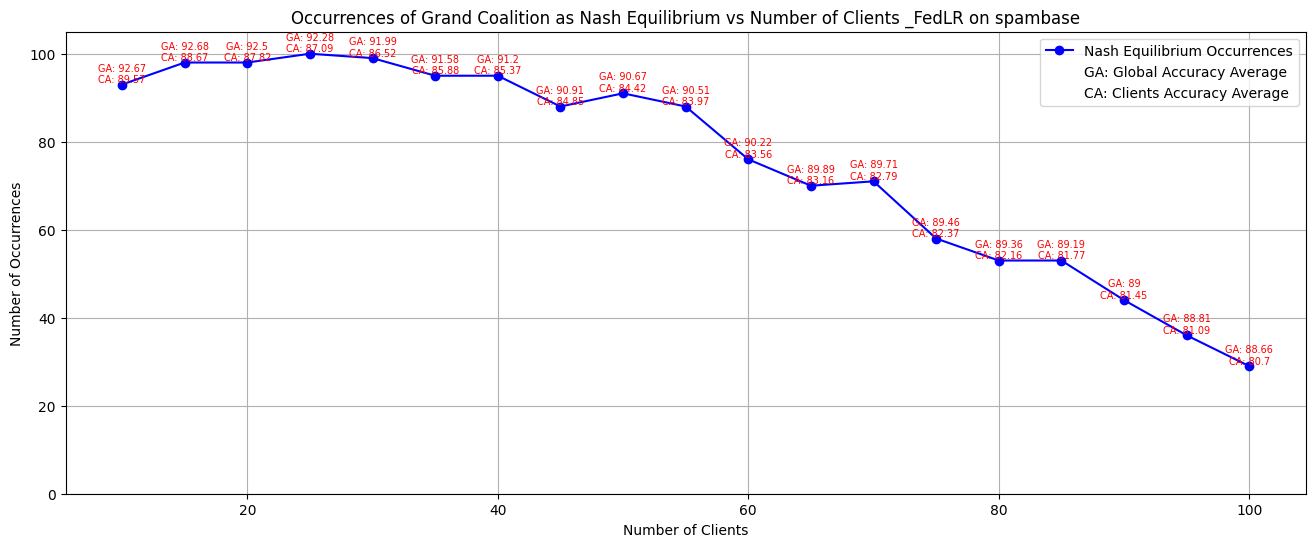

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.lines import Line2D


save_dir = "..."
approach = 'fedlr'
client_range = range(10, 101, 5)  


occurrence_counts = []
global_acc_avgs = []
clients_acc_avgs = []

for n_clients in client_range:
    file_path = os.path.join(save_dir, f"Nash_Equilibrium_Details_{approach}_nclients_{n_clients}.csv")
    
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)

        count = len(df)
        occurrence_counts.append(count)
        

        if 'Global Accuracy' in df.columns:
            global_avg = df['Global Accuracy'].mean()
        else:
            global_avg = np.nan
        global_acc_avgs.append(global_avg)

        client_cols = [col for col in df.columns if col.startswith("Client") and "Accuracy" in col]
        if client_cols:
            clients_avg = df[client_cols].mean().mean()
        else:
            clients_avg = np.nan
        clients_acc_avgs.append(clients_avg)
    else:

        occurrence_counts.append(0)
        global_acc_avgs.append(np.nan)
        clients_acc_avgs.append(np.nan)
        print(f"File not found: {file_path}")

plt.figure(figsize=(16, 6))
plt.yticks(np.arange(0, 101, 20))
plt.ylim(0, 105)
line, = plt.plot(list(client_range), occurrence_counts, marker='o', linestyle='-',color= 'blue', label='Nash Equilibrium Occurrences')
plt.title("Occurrences of Grand Coalition as Nash Equilibrium vs Number of Clients _FedLR on spambase")
plt.xlabel("Number of Clients")
plt.ylabel("Number of Occurrences")
plt.grid(True)


for x, occ, g_avg, c_avg in zip(client_range, occurrence_counts, global_acc_avgs, clients_acc_avgs):
    annotation_text = f"GA: {100*g_avg:.4g}\nCA: {100*c_avg:.4g}"
    plt.text(x, occ, annotation_text, color='red', fontsize=7, ha='center', va='bottom')

ga_legend = Line2D([], [], color='red', marker='None', linestyle='None', label='GA: Global Accuracy Average')
ca_legend = Line2D([], [], color='red', marker='None', linestyle='None', label='CA: Clients Accuracy Average')


plt.legend(handles=[line, ga_legend, ca_legend])
plt.show()


## Federated Learning (FedFor) _ without low-quality clients _ Spambase

In [15]:
import os, math, random, argparse, ast, copy
from collections import Counter, defaultdict
from itertools import chain, combinations
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [16]:
from utils.aggregate_functions import FederatedForest
from utils.DecisionTree import DecisionTree

In [14]:
def train_models_fedfor(partitions, X_test, y_test, max_depth):
    client_models = []
    client_global_accuracies = {}
    
    for i, (X_i, y_i) in enumerate(partitions):
        model = DecisionTreeClassifier(max_depth=max_depth, random_state=np.random.randint(0, 100000))
        model.fit(X_i, y_i)
        client_models.append(model)
        y_pred = model.predict(X_test)
        client_global_accuracies[i] = np.mean(y_pred == y_test)  
    return client_models, client_global_accuracies

In [ ]:
n_trials = 50
base_random_seed = 42
max_depths = [10, 100]
approach = 'fedfor'


save_dir = "..."
os.makedirs(save_dir, exist_ok=True)


for n_clients in range(10, 101, 5):
    print(f"Running experiments for n_clients = {n_clients}")
    all_details_for_client = []  


    for max_depth in max_depths:
        nash_counts = Counter()
        details_for_this_param = []
        client_accuracy_details = []

   
        for trial in range(n_trials):

            rand_component = random.randint(0, 500)
            trial_seed = base_random_seed + trial + int(1000 * max_depth) + 2 * rand_component


            partitions = split_data_equal(
                X_train, y_train,
                n_clients=n_clients,
                shuffle=True,
                random_seed=trial_seed
            )


            client_models, client_global_acc = train_models_fedfor(
                partitions=partitions,
                X_test=X_test,
                y_test=y_test,
                max_depth=max_depth
            )


            df_results = evaluate_coalitions2(
                client_models=client_models,
                client_global_accuracies=client_global_acc,
                n_clients=n_clients,
                aggregator_func=FederatedForest,
                X_test=X_test,
                y_test=y_test,
                corrupt_client_indices=[],
                approach=approach
            )
            df_results['Trial'] = trial + 1
            df_results['Max Iter or Depth'] = max_depth

            df_nash = find_nash_equilibria_v2(df_results.reset_index())
            if not df_nash.empty and 'Combination' in df_nash.columns:
                for coalition in df_nash['Combination']:
                    nash_counts[coalition] += 1

            df_nash['Trial'] = trial + 1
            df_nash['Max Iter or Depth'] = max_depth
            details_for_this_param.append(df_nash)


            trial_acc = {
                'Trial': trial + 1,
                'Max Iter or Depth': max_depth,
            }
            for j in range(n_clients):
                col_name = f'Client {j+1} Accuracy'
                trial_acc[col_name] = client_global_acc[j] if client_global_acc[j] is not None else np.nan
            client_accuracy_details.append(trial_acc)


        df_details = pd.concat(details_for_this_param, ignore_index=True)
        df_client_accuracy = pd.DataFrame(client_accuracy_details)
        df_combined = df_details.merge(
            df_client_accuracy,
            on=['Trial', 'Max Iter or Depth'],
            how='left'
        )

        df_combined['n_clients'] = n_clients
        all_details_for_client.append(df_combined)

    final_details_df = pd.concat(all_details_for_client, ignore_index=True)

    details_path = os.path.join(save_dir, f"Nash_Equilibrium_Details_{approach}_nclients_{n_clients}.csv")
    final_details_df.to_csv(details_path, index=False)


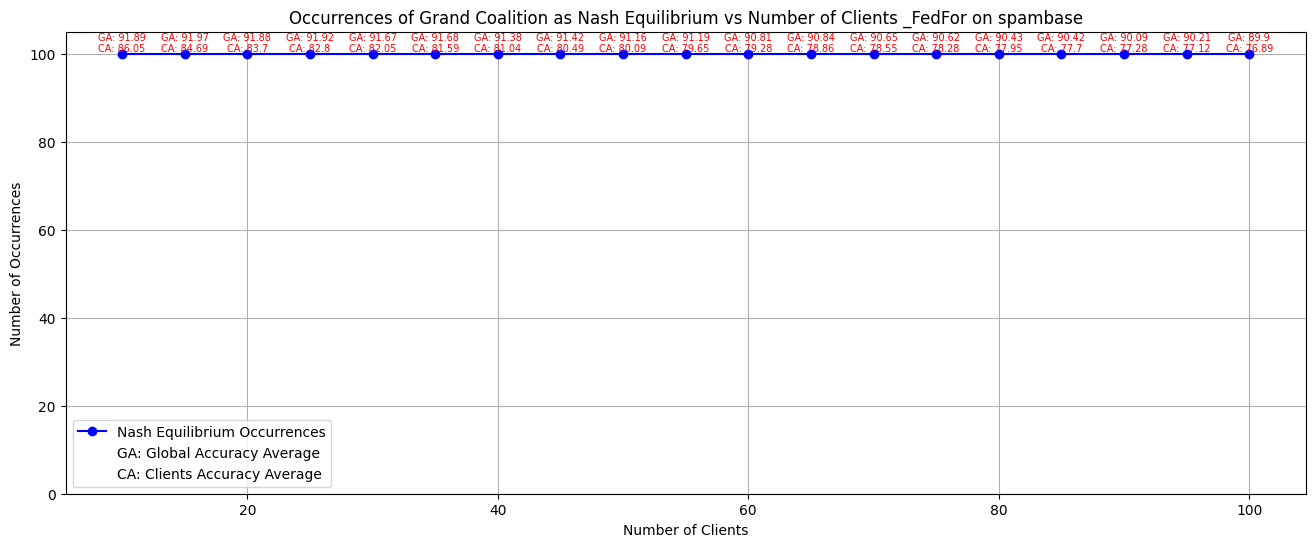

In [ ]:
save_dir = "..."
approach = 'fedfor'
client_range = range(10, 101, 5)  


occurrence_counts = []
global_acc_avgs = []
clients_acc_avgs = []

for n_clients in client_range:
    file_path = os.path.join(save_dir, f"Nash_Equilibrium_Details_{approach}_nclients_{n_clients}.csv")
    
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)

        count = len(df)
        occurrence_counts.append(count)
        

        if 'Global Accuracy' in df.columns:
            global_avg = df['Global Accuracy'].mean()
        else:
            global_avg = np.nan
        global_acc_avgs.append(global_avg)

        client_cols = [col for col in df.columns if col.startswith("Client") and "Accuracy" in col]
        if client_cols:
            clients_avg = df[client_cols].mean().mean()
        else:
            clients_avg = np.nan
        clients_acc_avgs.append(clients_avg)
    else:

        occurrence_counts.append(0)
        global_acc_avgs.append(np.nan)
        clients_acc_avgs.append(np.nan)
        print(f"File not found: {file_path}")

plt.figure(figsize=(16, 6))
plt.yticks(np.arange(0, 101, 20))
plt.ylim(0, 105)
line, = plt.plot(list(client_range), occurrence_counts, marker='o', linestyle='-',color= 'blue', label='Nash Equilibrium Occurrences')
plt.title("Occurrences of Grand Coalition as Nash Equilibrium vs Number of Clients _FedFor on spambase")
plt.xlabel("Number of Clients")
plt.ylabel("Number of Occurrences")
plt.grid(True)


for x, occ, g_avg, c_avg in zip(client_range, occurrence_counts, global_acc_avgs, clients_acc_avgs):
    annotation_text = f"GA: {100*g_avg:.4g}\nCA: {100*c_avg:.4g}"
    plt.text(x, occ, annotation_text, color='red', fontsize=7, ha='center', va='bottom')

ga_legend = Line2D([], [], color='red', marker='None', linestyle='None', label='GA: Global Accuracy Average')
ca_legend = Line2D([], [], color='red', marker='None', linestyle='None', label='CA: Clients Accuracy Average')


plt.legend(handles=[line, ga_legend, ca_legend])
plt.show()
